# Correlations between fire burned area and climate variability

Author: Jatan Buch (v1, 210714) || (v2, 210729) || (v3, 210805) || (v4, 210916) || (v5, 211115)

In [1]:
import numpy as np
from scipy import stats, optimize, interpolate
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LassoLarsCV, LassoLarsIC, RidgeCV, ElasticNetCV

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from stats_utils import reg_uni_climate_fire_corr, reg_multi_climate_fire_corr

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir= "../data/"
pred_input_path= "12km/"
resp_input_path= "firelist/"
outfilepath= "./plots/"

## Data pre-processing

In [ ]:
regname= {1: "ca_sierra", 2: "ca_north_coast", 3: "ca_cent_coast", 4: "ca_south_coast", 5: "pnw_mts", 6: "columbia_plateau", 7:"northern_rockies", \
          8: "middle_rockies", 9: "southern_rockies", 10: "am_semidesert", 11: "aznm_mts", 12: "im_semidesert", 13: "im_desert", 14: "northern_great_plains", \
          15: "high_plains", 16: "colorado_plateau", 17: "sw_tablelands", 18: "ch_desert"}
fire_file= "../data/burnarea_12km.nc"

for r in tqdm(range(len(regname))):
    data_df= init_fire_size_df(firefile= fire_file, regindx= r+1, lflag= 'L4')
    data_df.to_hdf(data_dir + 'clim_reg_l4_fire_sizes/clim_%s'%regname[r+1] + '_l4_fire_size_data.h5', key= 'df', mode= 'w')

  0%|                                                                                                                                                                                                                                                                                                  | 0/18 [00:00<?, ?it/s]

Creating dataframe for ca_sierra


  6%|███████████████▍                                                                                                                                                                                                                                                                      | 1/18 [22:18<6:19:19, 1338.78s/it]

Creating dataframe for ca_north_coast


 11%|██████████████████████████████▉                                                                                                                                                                                                                                                       | 2/18 [38:55<5:03:25, 1137.83s/it]

Creating dataframe for ca_cent_coast


 17%|██████████████████████████████████████████████                                                                                                                                                                                                                                      | 3/18 [1:10:26<6:10:22, 1481.48s/it]

Creating dataframe for ca_south_coast


 22%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                      | 4/18 [1:24:18<4:45:51, 1225.11s/it]

Creating dataframe for pnw_mts


 28%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                       | 5/18 [1:55:02<5:13:46, 1448.21s/it]

Creating dataframe for columbia_plateau


 33%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                        | 6/18 [2:05:10<3:52:32, 1162.73s/it]

Creating dataframe for northern_rockies


 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 7/18 [2:26:09<3:38:55, 1194.14s/it]

Creating dataframe for middle_rockies


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 8/18 [3:09:35<4:33:56, 1643.61s/it]

Creating dataframe for southern_rockies


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 9/18 [3:21:28<3:22:53, 1352.56s/it]

Creating dataframe for am_semidesert


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 10/18 [3:43:18<2:58:36, 1339.58s/it]

Creating dataframe for aznm_mts


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 11/18 [3:55:31<2:14:36, 1153.83s/it]

Creating dataframe for im_semidesert


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 12/18 [4:16:29<1:58:32, 1185.47s/it]

Creating dataframe for im_desert


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 13/18 [4:38:17<1:41:53, 1222.67s/it]

Creating dataframe for northern_great_plains


In [4]:
#%time data_df= init_fire_df(firefile= fire_file, fflag= 'size')
#data_df.to_hdf(data_dir + 'clim_fire_size_data.h5', key= 'df', mode= 'w')

## Monthly burned areas

In [4]:
tot_months= 36*12
month_arr= np.linspace(0, tot_months - 1, tot_months, dtype= int)
year_arr= np.asarray([1984, 1991, 1998, 2005, 2012, 2019]) 

ind_grid= [[1, 2, 3], [5, 6, 7], [8, 9, 11], [12, 13, 14]]
reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains"}

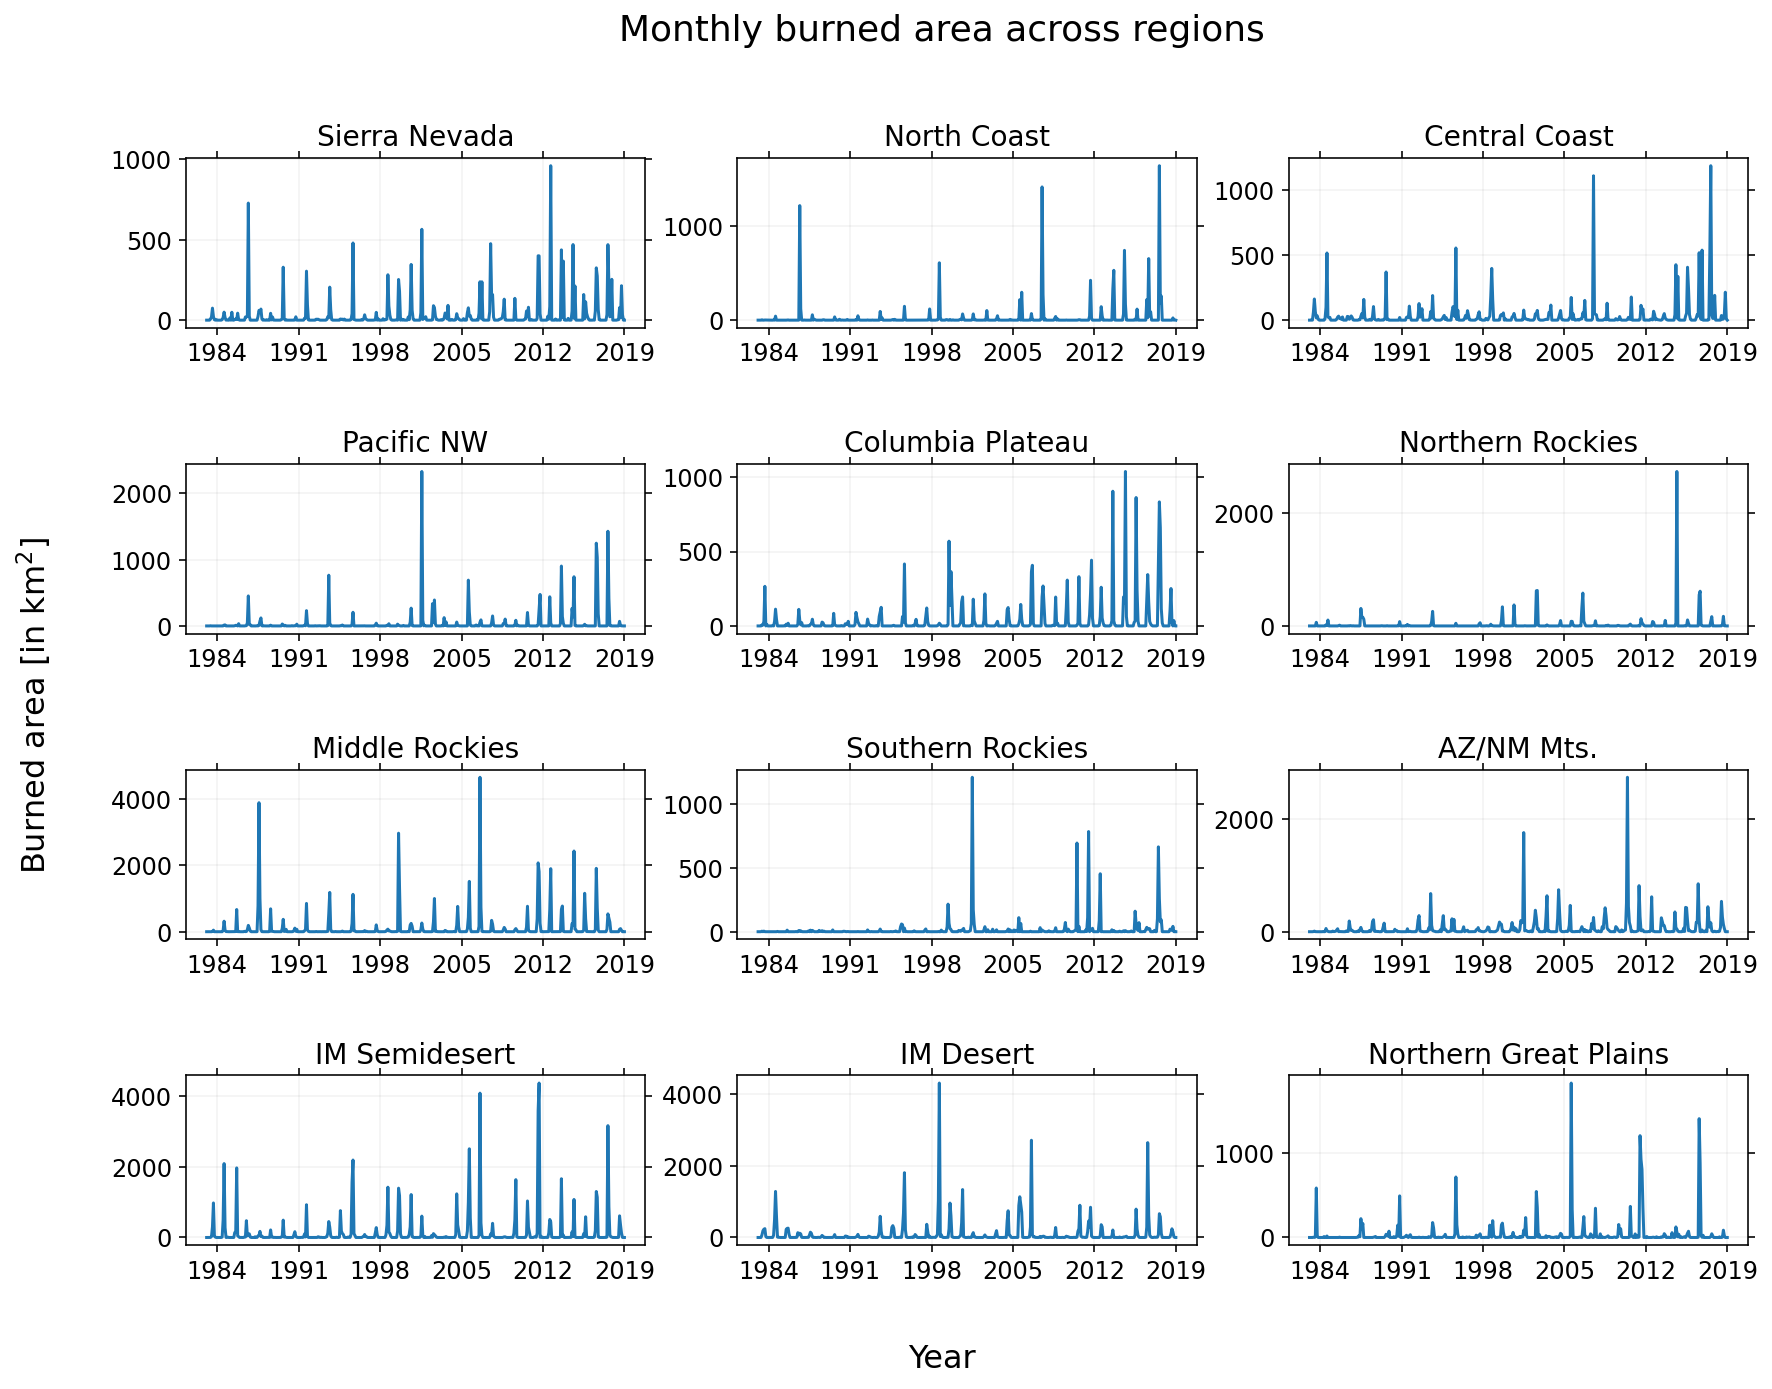

In [5]:
fig, ax= plt.subplots(4, 3, figsize=(14, 10))
plt.suptitle(r'Monthly burned area across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Burned area [in ${\rm km}^2$]', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(4):
    for j in range(3):
        ax[i, j].plot(month_arr, mon_burned_area(firefile= fire_file, regindx= ind_grid[i][j], final_year= 2019));
        ax[i, j].set_title(reg_name[ind_grid[i][j]], fontsize= 14);
        
        ax[i, j].set_xticks((year_arr - 1984 + 1)*12 - 1);
        ax[i, j].set_xticklabels(year_arr)
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

#plt.savefig(outfilepath + 'all_region_burnedarea.pdf', bbox_inches='tight');

## Extreme value distribution of burned areas

We first plot the frequency distribution of burned area sizes for three representative years that we chose above. Note that currently we are using the entire study region provided in the data set. Our preliminary goal is to determine whether the generalized Pareto distribution (GPD) gives a reasonable fit for each of these fires individually and report the corresponding MLE parameters. 

In [11]:
burnarea_1987= wildfire_df[(wildfire_df['final_year'] == 1987)&(wildfire_df['final_forest_area_ha'] > 0)]['final_forest_area_ha']
burnarea_1999= wildfire_df[(wildfire_df['final_year'] == 1999)&(wildfire_df['final_forest_area_ha'] > 0)]['final_forest_area_ha']
burnarea_2018= wildfire_df[(wildfire_df['final_year'] == 2018)&(wildfire_df['final_forest_area_ha'] > 0)]['final_forest_area_ha']
burnarea_all= wildfire_df[wildfire_df['final_forest_area_ha'] > 0]['final_forest_area_ha']

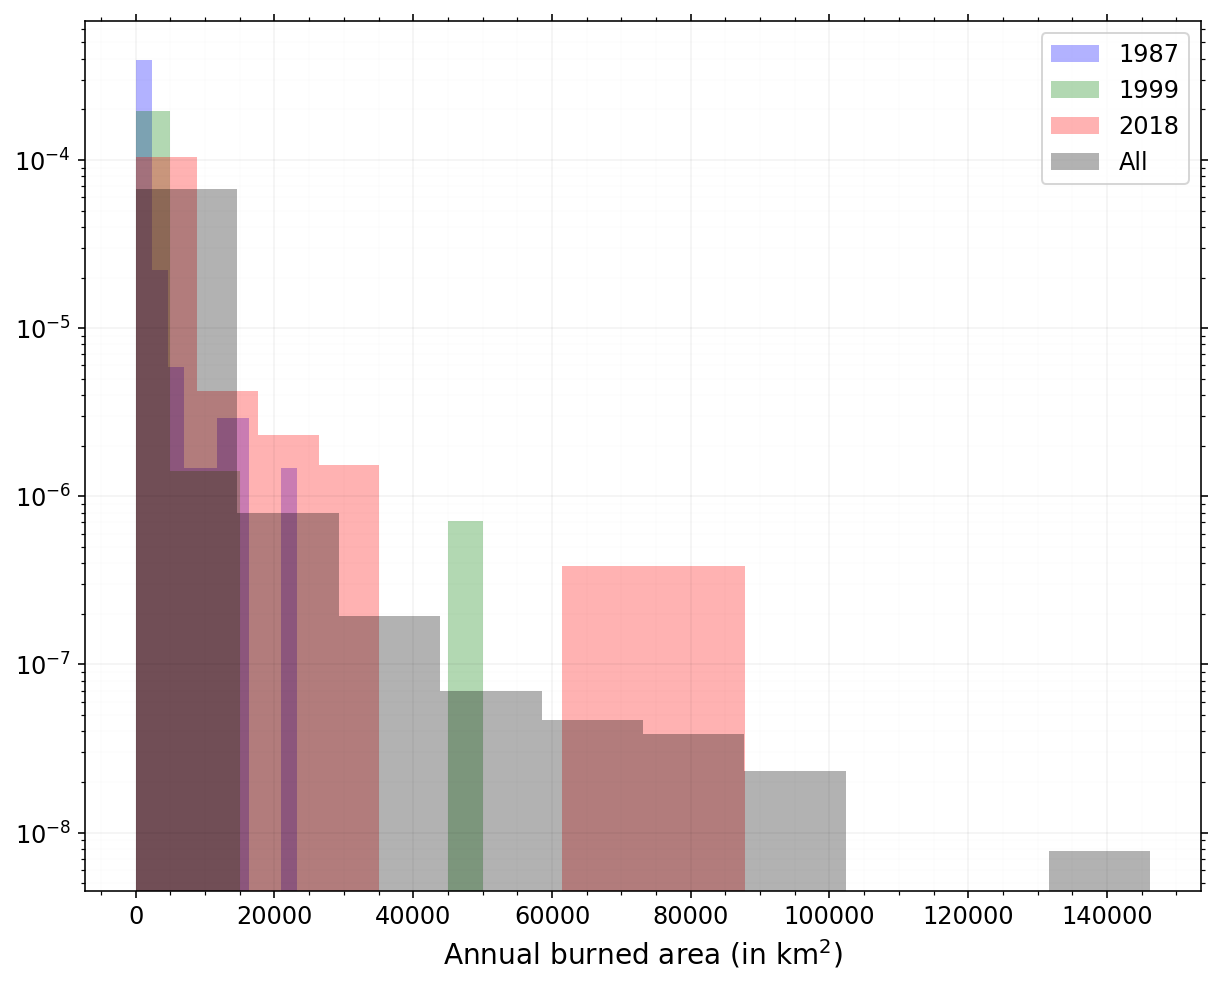

In [27]:
fig, ax= plt.subplots(figsize=(10, 8))

ax.hist(burnarea_1987, density= True, histtype= 'stepfilled', color= 'blue', alpha= 0.3, label= r'1987');
ax.hist(burnarea_1999, density= True, histtype= 'stepfilled', color= 'green', alpha= 0.3, label= r'1999');
ax.hist(burnarea_2018, density= True, histtype= 'stepfilled', color= 'red', alpha= 0.3, label= r'2018');
ax.hist(burnarea_all, density= True, histtype= 'stepfilled', color= 'black', alpha= 0.3, label= r'All');
plt.yscale('log');
ax.set_xlabel(r'Annual burned area (in ${\rm km}^2$)', fontsize= 14);

plt.minorticks_on();
plt.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

plt.legend(loc='upper right', frameon=True, fontsize=12);

## CA fire burned area 

After clipping the data according to different CA regions selected by Williams et al. 2019; note that the total study domain is simply the linear sum of the different regions.

In [4]:
burnarea_ncoast_data= bailey_ecoprovince_mask(fire_file, region= "ca_north_coast");
burnarea_sierra_data= bailey_ecoprovince_mask(fire_file, region= "ca_sierra");
burnarea_ccoast_data= bailey_ecoprovince_mask(fire_file, region= "ca_cent_coast");
burnarea_scoast_data= bailey_ecoprovince_mask(fire_file, region= "ca_south_coast");
burnarea_tot_data= bailey_ecoprovince_mask(fire_file, region= "ca_total");

times= burnarea_data['time']
dates= num2date(times[:], units=times.units)
ind_1987= (dates.data > DatetimeGregorian(1986, 12, 15, 0, 0, 0, 0)) & (dates.data < DatetimeGregorian(1988, 1, 15, 0, 0, 0, 0))
ind_1999= (dates.data > DatetimeGregorian(1998, 12, 15, 0, 0, 0, 0)) & (dates.data < DatetimeGregorian(2000, 1, 15, 0, 0, 0, 0))
ind_2018= (dates.data > DatetimeGregorian(2017, 12, 15, 0, 0, 0, 0)) & (dates.data < DatetimeGregorian(2019, 1, 15, 0, 0, 0, 0))

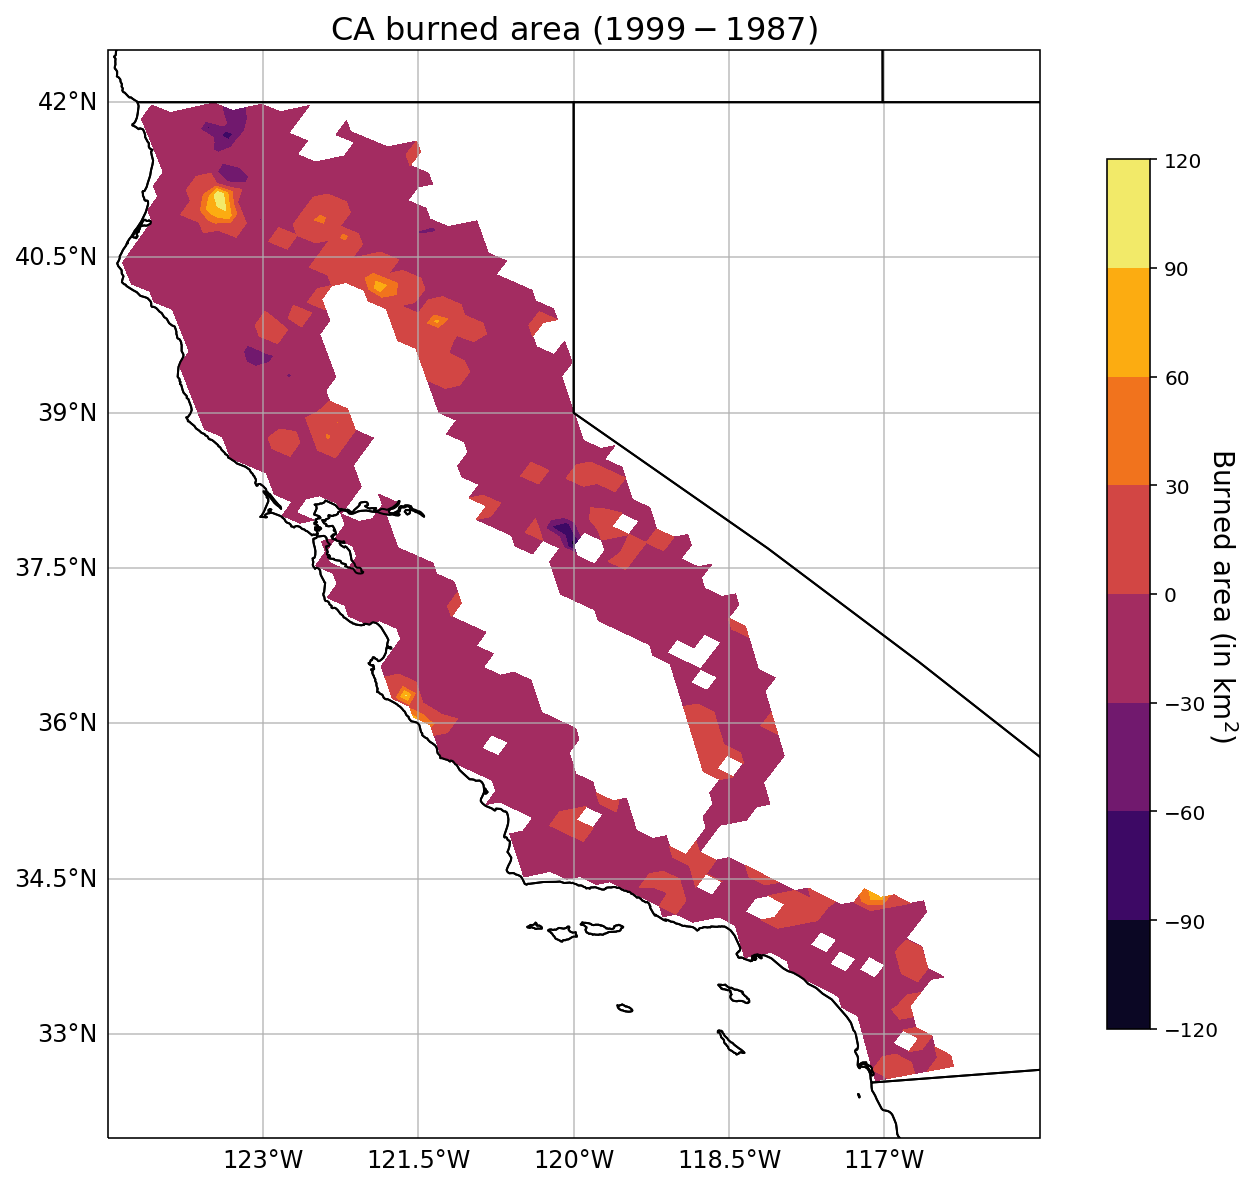

In [7]:
extent = [-124.5, -115.5, 32, 42.5] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(12, 10))
#ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent);

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl= ax.gridlines(draw_labels=True, alpha= 0.8, zorder= 1);
gl.top_labels = False;
gl.right_labels = False;
gl.xlabel_style = {'size': 12};
gl.ylabel_style = {'size': 12};

CS = ax.contourf(lat_long_fire_grid[1], lat_long_fire_grid[0], np.sum(burnarea_tot_data.values[ind_1999], axis= 0) - \
                                            np.sum(burnarea_tot_data.values[ind_1987], axis= 0), cmap=plt.cm.inferno)
cbar= fig.colorbar(CS, ax= ax, shrink= 0.8)
cbar.ax.set_ylabel(r'Burned area [in ${\rm km}^2$]', fontsize= 14, labelpad= 10, rotation= 270)

ax.set_title(r'${\rm CA \ burned \ area \ (1999 - 1987)}$', fontsize= 16);
#plt.savefig(outfilepath + 'ca_burn_area_99_87.pdf', bbox_inches='tight');

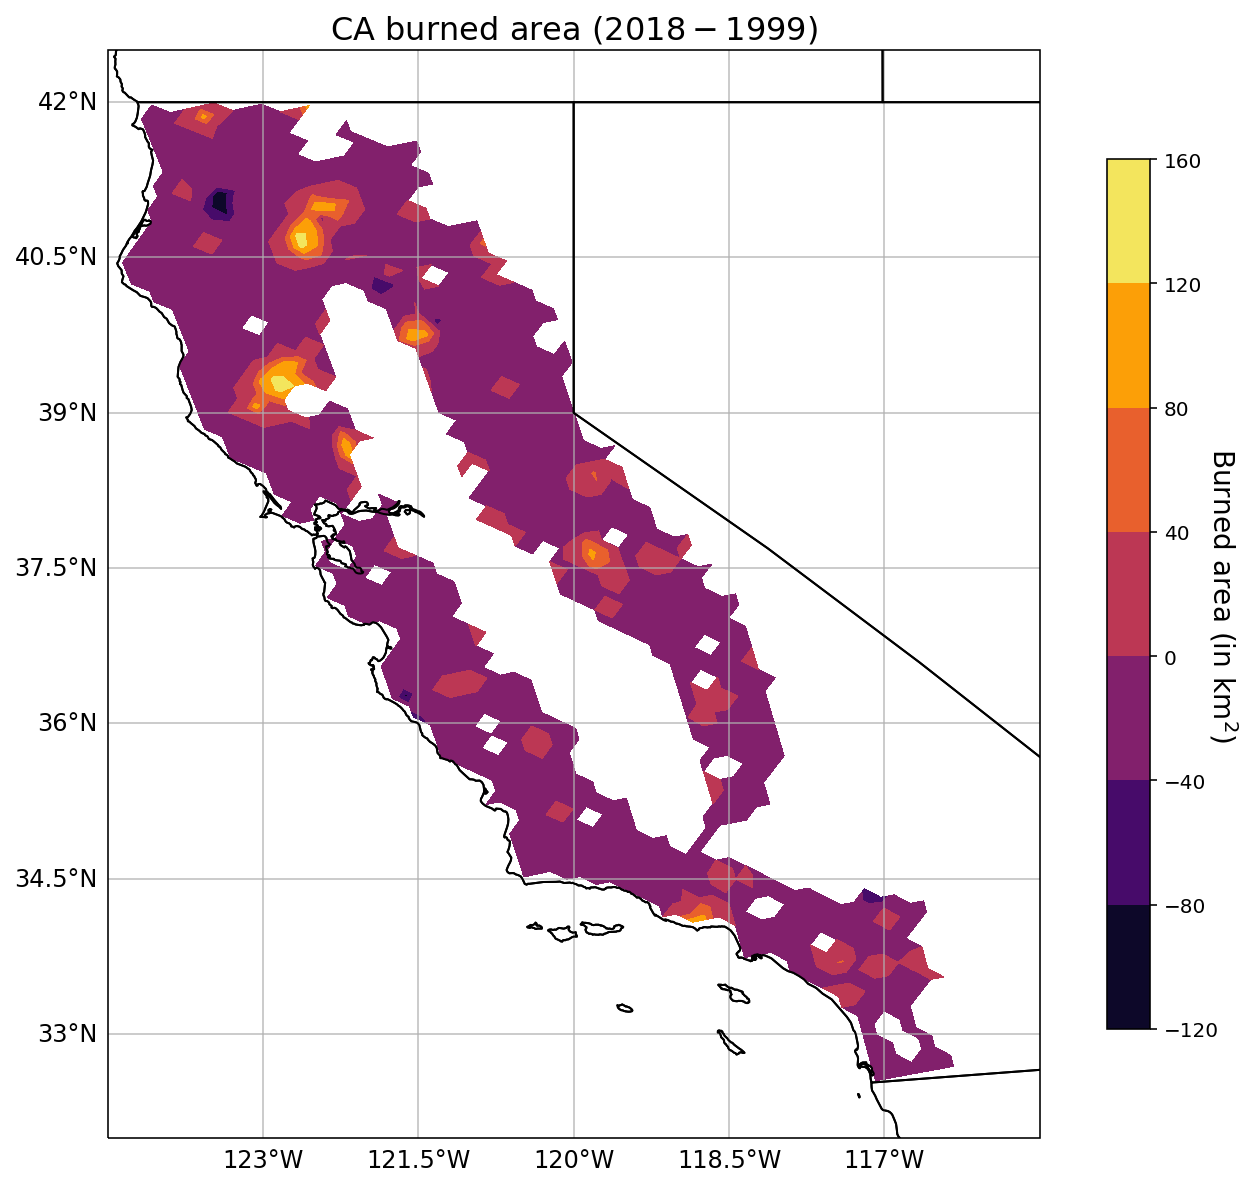

In [8]:
extent = [-124.5, -115.5, 32, 42.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(12, 10))
#ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent);

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl= ax.gridlines(draw_labels=True, alpha= 0.8, zorder= 1);
gl.top_labels = False;
gl.right_labels = False;
gl.xlabel_style = {'size': 12};
gl.ylabel_style = {'size': 12};

CS = ax.contourf(lat_long_fire_grid[1], lat_long_fire_grid[0], np.sum(burnarea_tot_data.values[ind_2018], axis= 0) - \
                                            np.sum(burnarea_tot_data.values[ind_1999], axis= 0), cmap=plt.cm.inferno)
cbar= fig.colorbar(CS, ax= ax, shrink= 0.8)
cbar.ax.set_ylabel(r'Burned area [in ${\rm km}^2$]', fontsize= 14, labelpad= 10, rotation= 270)

ax.set_title(r'${\rm CA \ burned \ area \ (2018 - 1999)}$', fontsize= 16);
#plt.savefig(outfilepath + 'ca_burn_area_18_99.pdf', bbox_inches='tight');

## Burned area - climate correlation

### Univariate regression

In [6]:
sierra_sum_burnarea= seas_burnarea(firefile= fire_file, season= "summer", regindx= 1)
pnw_sum_burnarea= seas_burnarea(firefile= fire_file, season= "summer", regindx= 5)

100%|██████████| 9/9 [00:23<00:00,  2.60s/it]


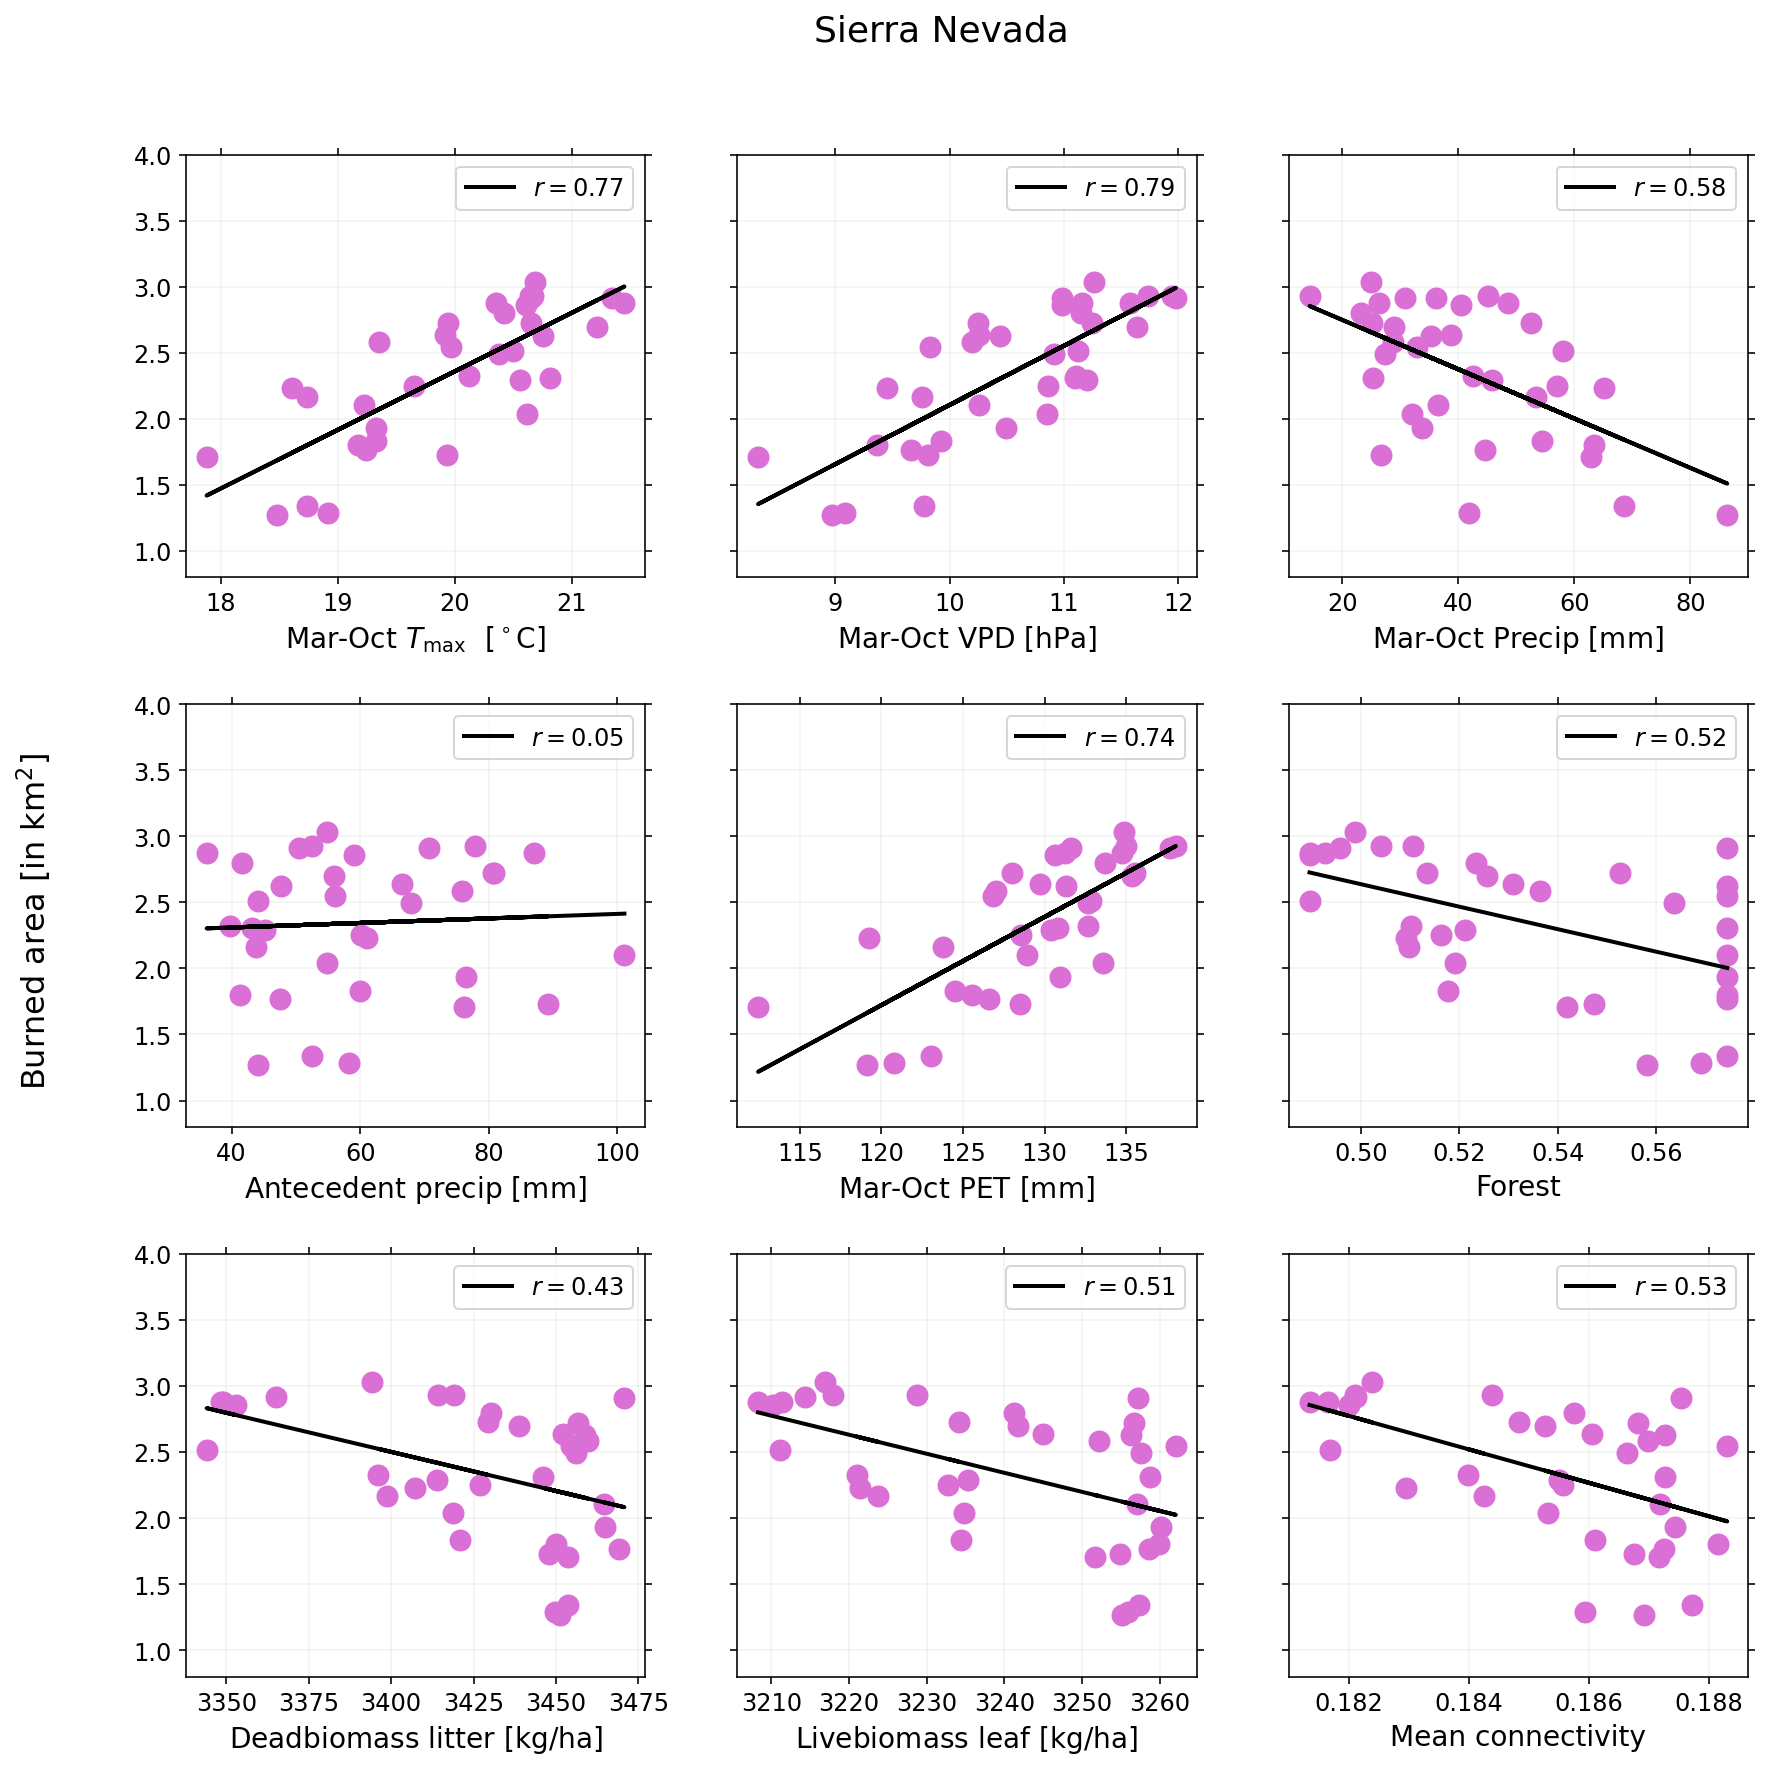

In [7]:
reg_uni_climate_fire_corr(sum_burnarea= sierra_sum_burnarea, regression= "uni_lsq", regindx= 1);

### Multivariate regression

LASSO prefers setting most of the covariates to zero, so in some sense there's a built-in sparsity preference. 

In [6]:
col_sum_burnarea= seas_burnarea(firefile= fire_file, season= "summer", regindx= 6)

In [8]:
burnarr_len= len(col_sum_burnarea)
pred_var_arr= ["Tmax", "VPD", "Precip", "Antecedent precip", "PET", "Forest"]
pred_season_data_arr= [clim_pred_var(pred_file_indx= i+1, pred_seas_indx= i+1, regindx= 6, burnarr_len= burnarr_len) \
                                                                                                        for i in range(len(pred_var_arr))]
des_mat= np.vstack(pred_season_data_arr).T
std_arr= np.std(des_mat, axis= 0) #np.sqrt(np.sum(des_mat ** 2, axis=0))
norm_des_mat= (des_mat - np.mean(des_mat, axis= 0))/std_arr
rescaled_log_area= (np.log10(col_sum_burnarea) - np.mean(np.log10(col_sum_burnarea)))/(np.std(np.log10(col_sum_burnarea)))

#model= LassoCV(alphas= [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], eps= 1e-4, cv= 10).fit(norm_des_mat, rescaled_log_area)
model= ElasticNetCV(l1_ratio= [0.01, 0.1, 0.3, 0.7, 0.9, 0.99], eps= 1e-4, n_alphas= 1000, cv= 10).fit(norm_des_mat, rescaled_log_area)

r2_mod= model.score(norm_des_mat, rescaled_log_area)
coeff_arr= model.coef_ #*std_arr

In [9]:
coeff_arr, r2_mod

(array([ 0.        ,  0.30445185,  0.        ,  0.16718109,  0.        ,
        -0.4587466 ], dtype=float32),
 0.5476276750226545)

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating the normalized climate-fire correlation coefficients for Sierra Nevada ...


 17%|█▋        | 1/6 [01:17<06:25, 77.11s/it]

Calculating the normalized climate-fire correlation coefficients for Pacific NW Mts. ...


 33%|███▎      | 2/6 [02:35<05:10, 77.59s/it]

Calculating the normalized climate-fire correlation coefficients for Middle Rockies ...


 50%|█████     | 3/6 [04:00<04:03, 81.27s/it]

Calculating the normalized climate-fire correlation coefficients for AZ/NM Mts. ...


 67%|██████▋   | 4/6 [05:19<02:40, 80.13s/it]

Calculating the normalized climate-fire correlation coefficients for IM Semidesert ...


 83%|████████▎ | 5/6 [06:57<01:26, 86.91s/it]

Calculating the normalized climate-fire correlation coefficients for IM Desert ...


100%|██████████| 6/6 [09:32<00:00, 95.37s/it] 


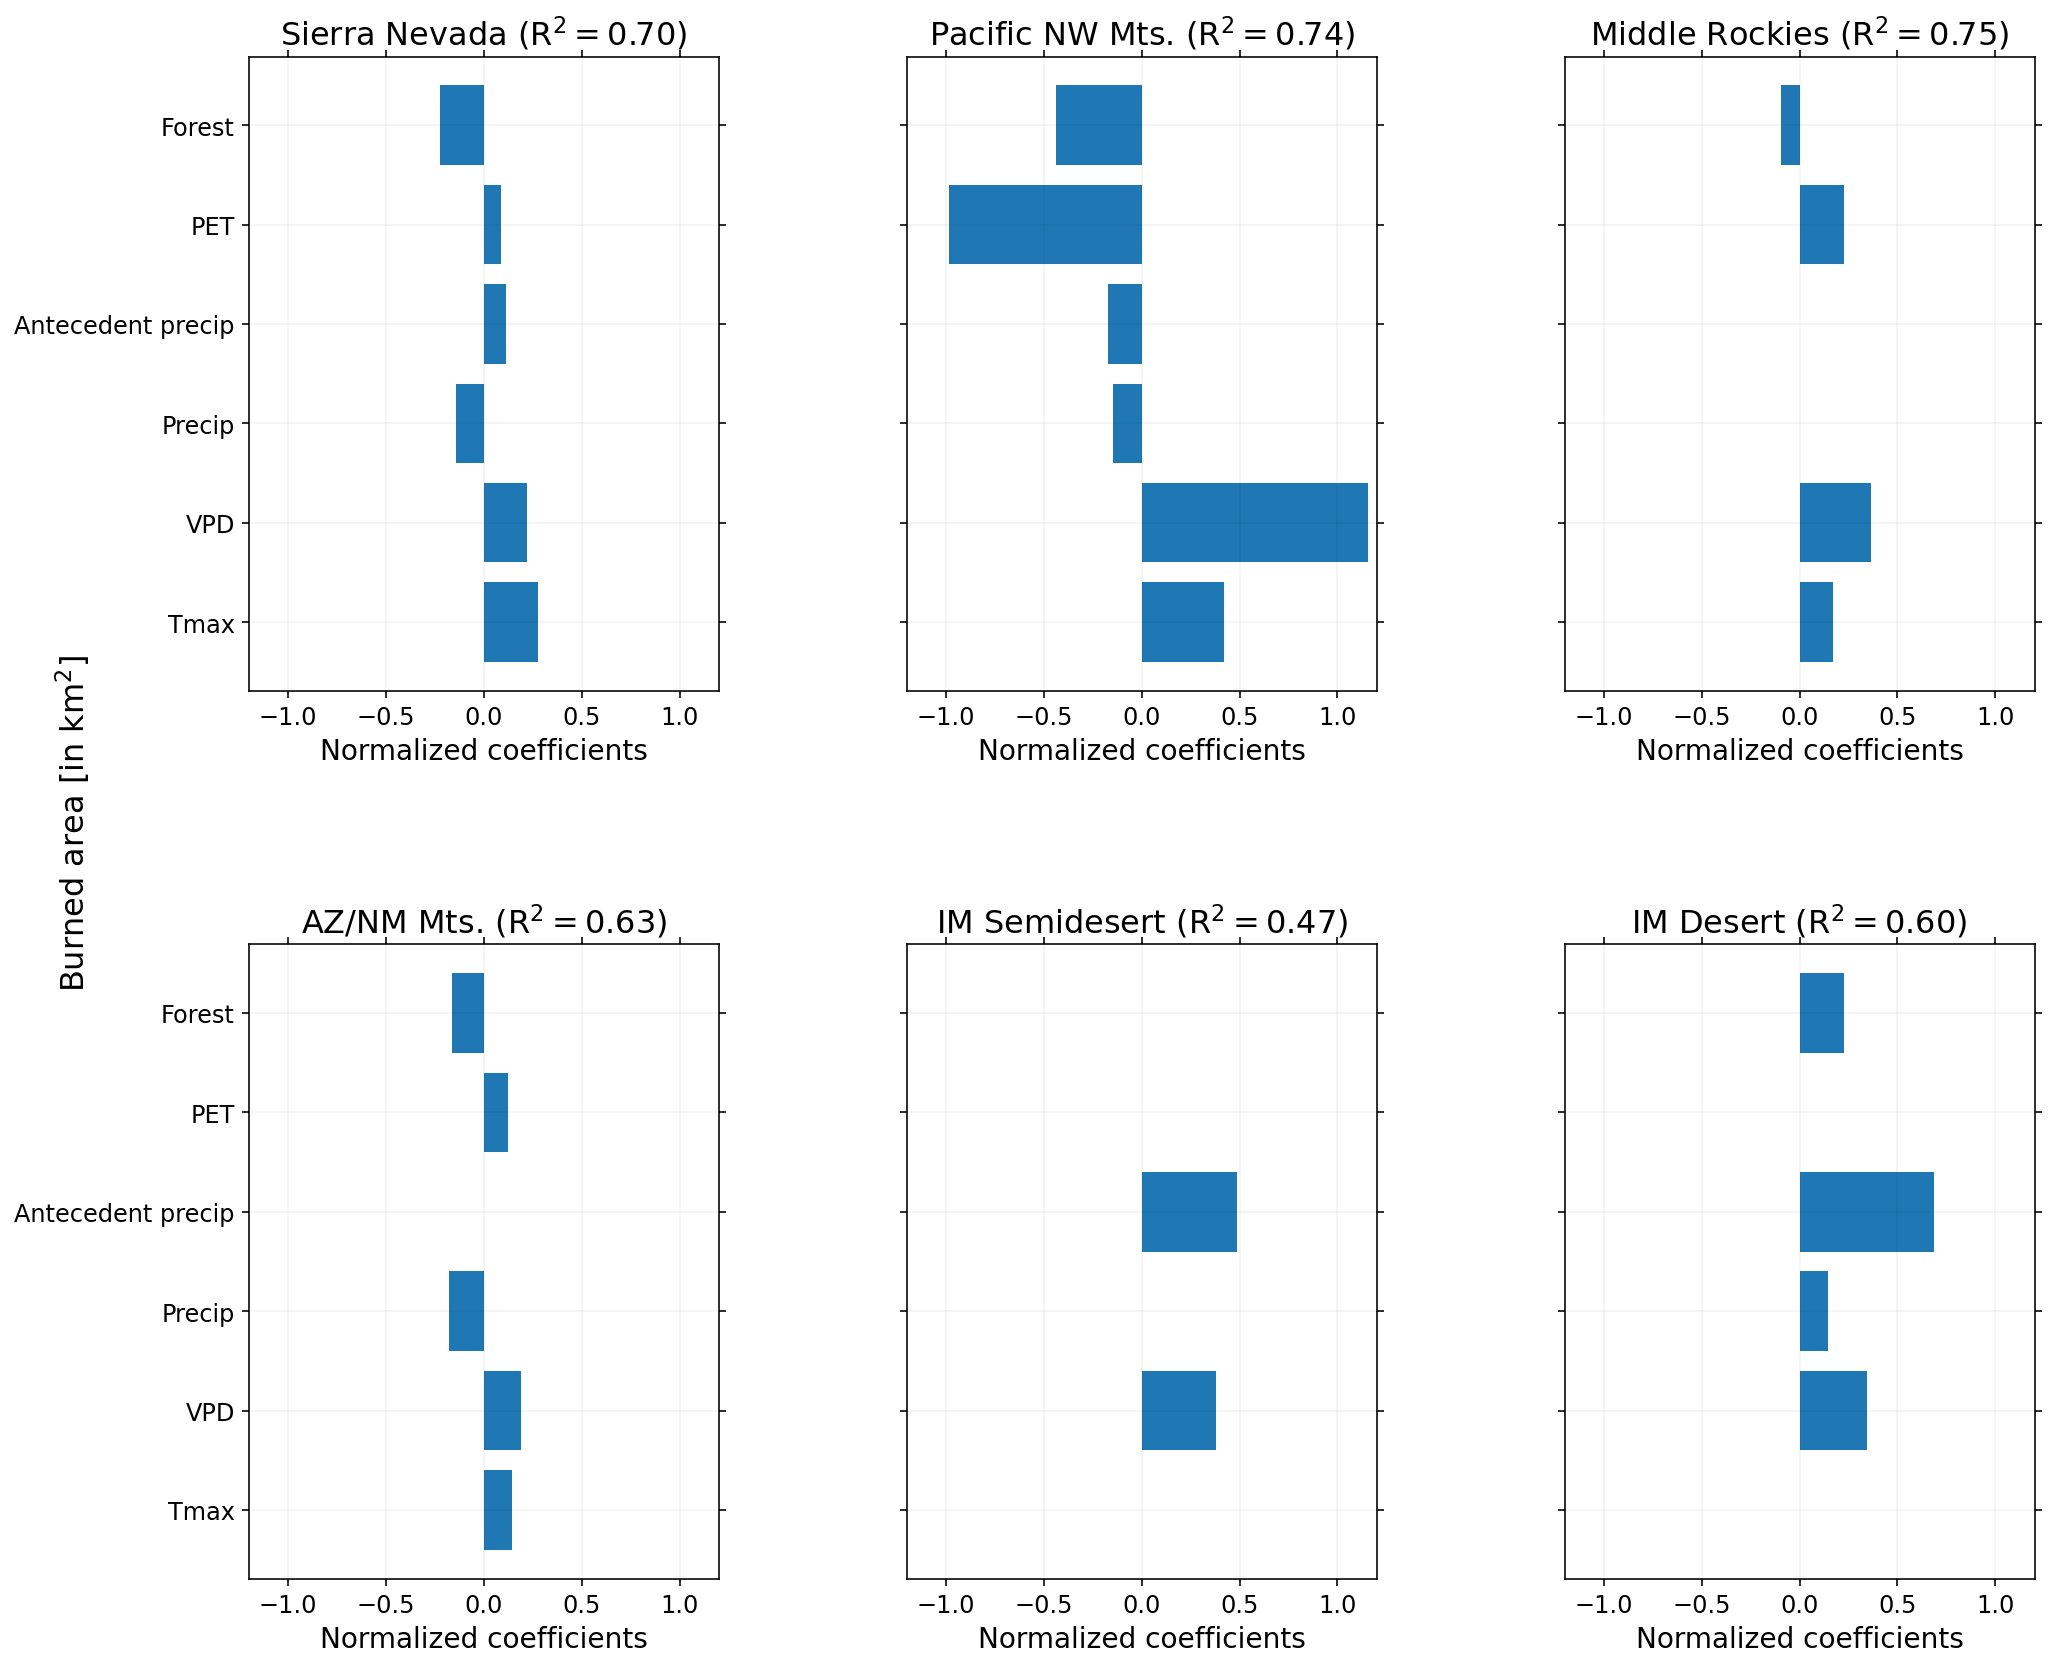

In [8]:
reg_multi_climate_fire_corr(firefile= fire_file, fireseason= "summer", regression= "enetCV")

  0%|          | 0/6 [00:00<?, ?it/s]

Calculating the normalized climate-fire correlation coefficients for Sierra Nevada ...


 17%|█▋        | 1/6 [01:08<05:44, 68.94s/it]

Calculating the normalized climate-fire correlation coefficients for Pacific NW Mts. ...


 33%|███▎      | 2/6 [02:18<04:36, 69.19s/it]

Calculating the normalized climate-fire correlation coefficients for Middle Rockies ...


 50%|█████     | 3/6 [03:28<03:28, 69.47s/it]

Calculating the normalized climate-fire correlation coefficients for AZ/NM Mts. ...


 67%|██████▋   | 4/6 [04:34<02:16, 68.44s/it]

Calculating the normalized climate-fire correlation coefficients for IM Semidesert ...


 83%|████████▎ | 5/6 [05:40<01:07, 67.41s/it]

Calculating the normalized climate-fire correlation coefficients for IM Desert ...


100%|██████████| 6/6 [06:46<00:00, 67.73s/it]


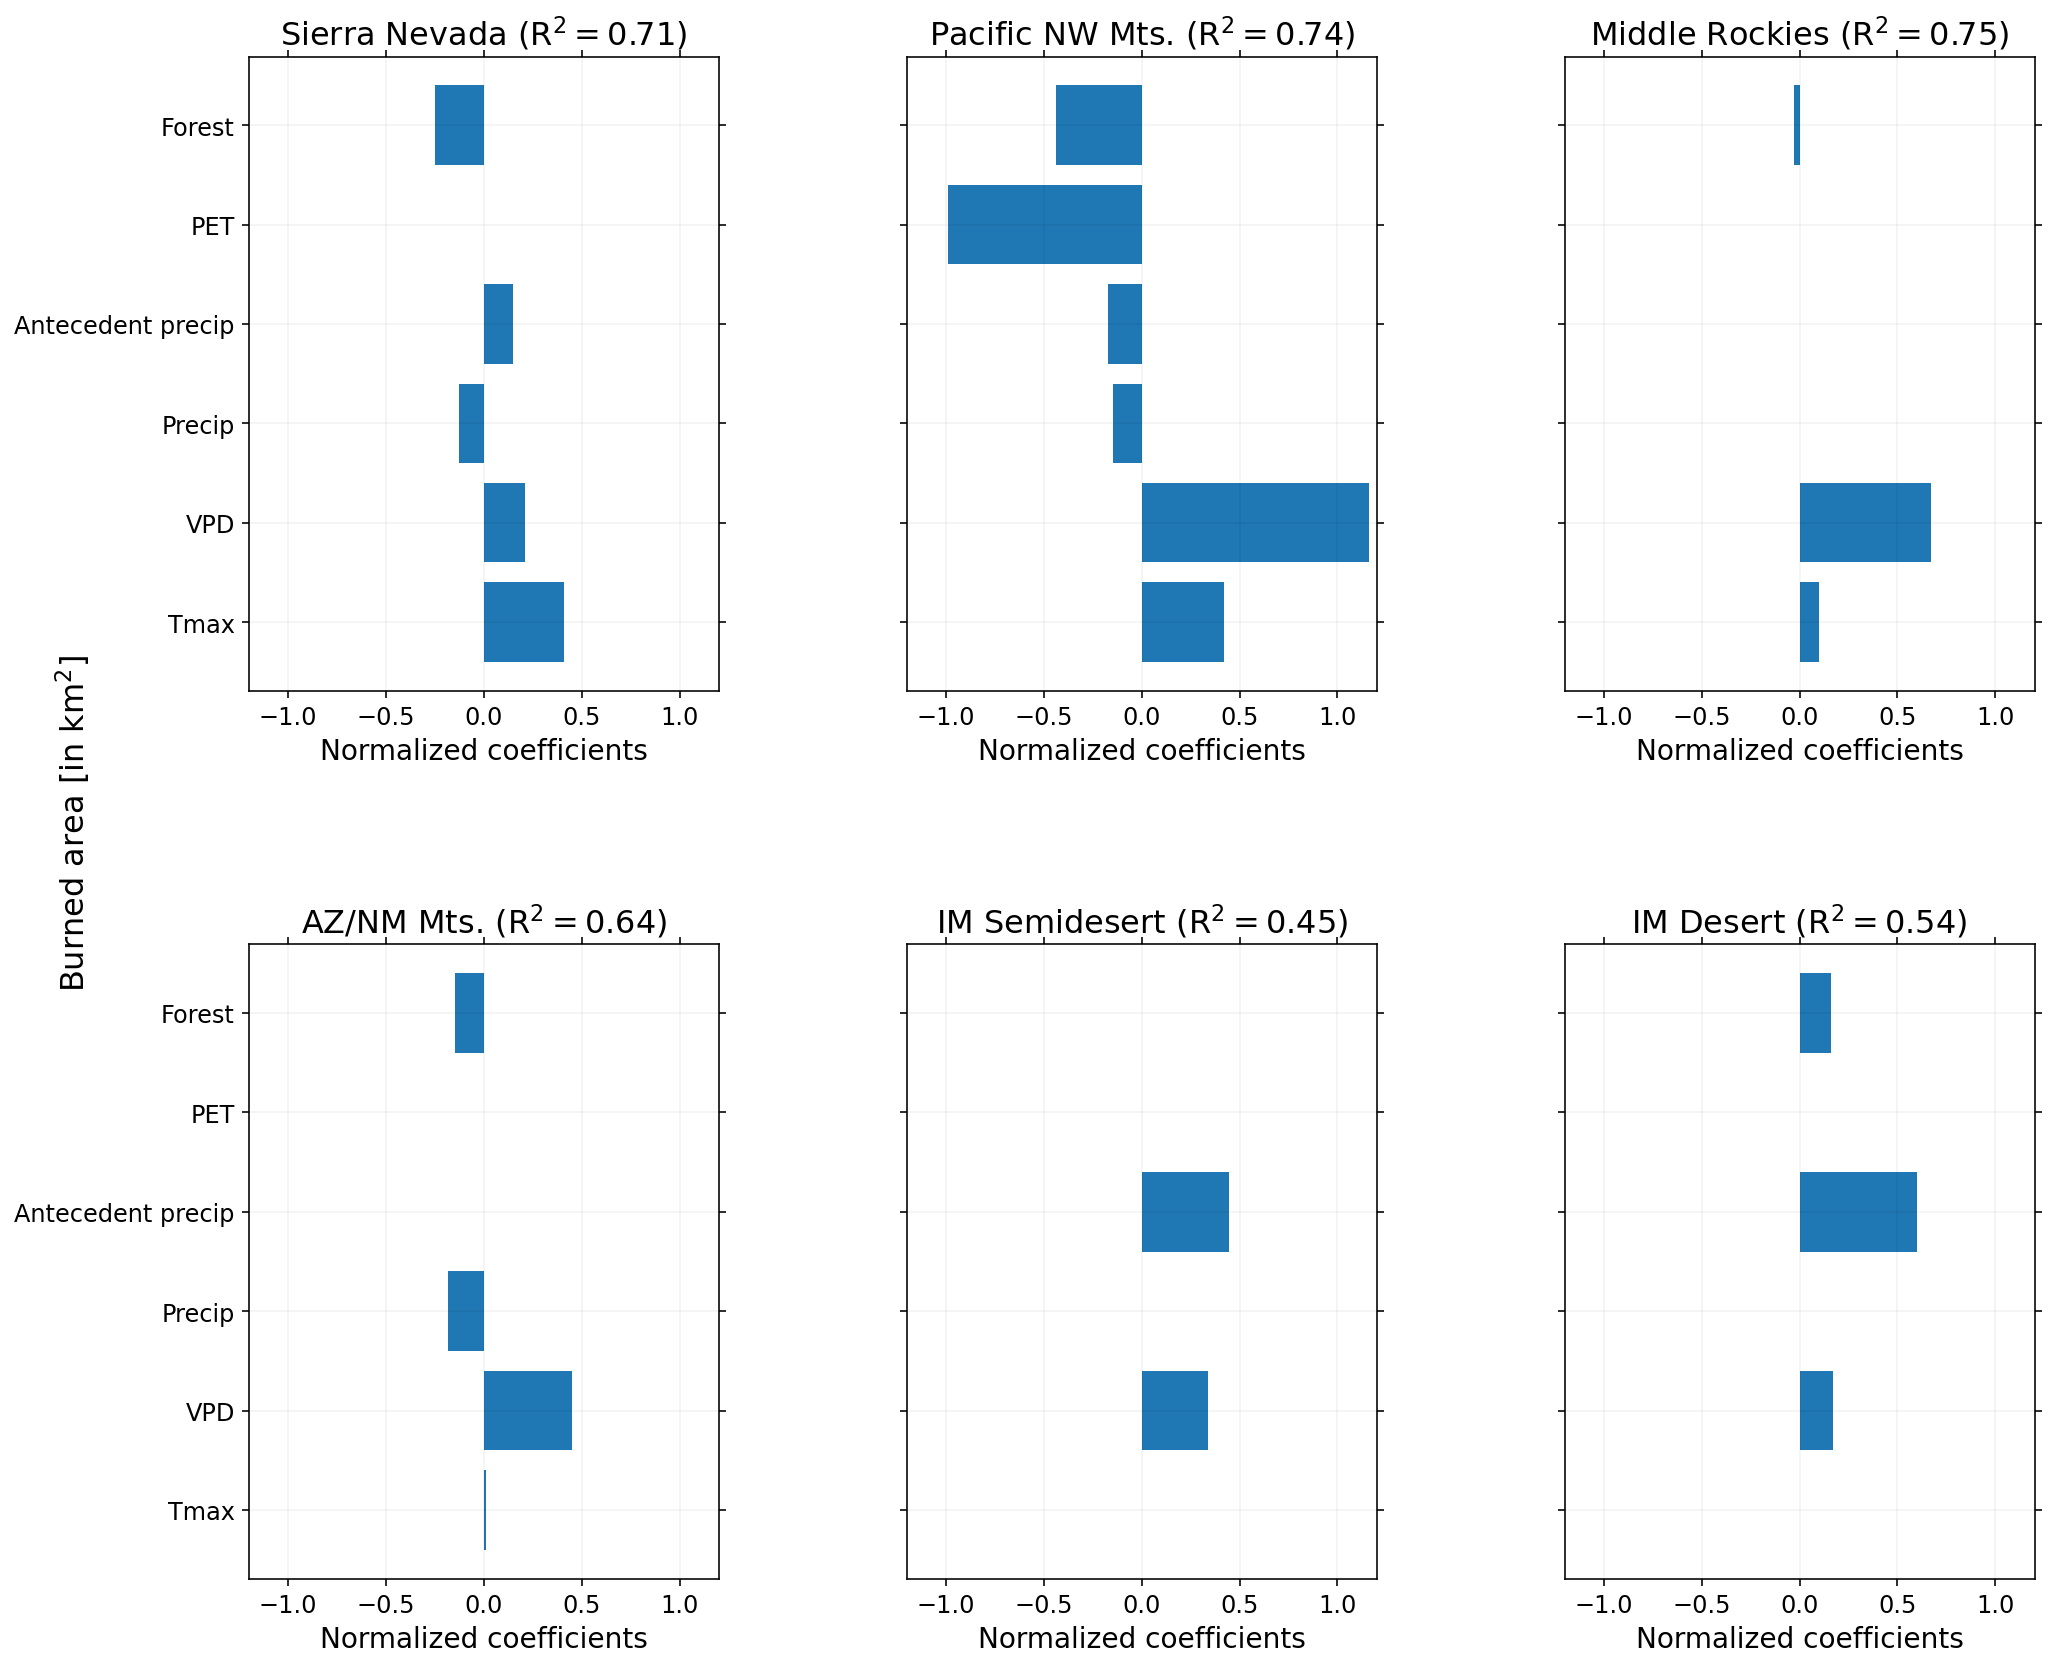

In [9]:
reg_multi_climate_fire_corr(firefile= fire_file, fireseason= "summer", regression= "lassoCV")

## Sandbox

### Selecting candidate regions

In [229]:
pnw_gdf= ecoregionshp[((ecoregionshp['STATE_NAME'] == 'Washington')|(ecoregionshp['STATE_NAME'] == 'Oregon'))&((ecoregionshp['US_L3CODE'] == '1')| \
            (ecoregionshp['US_L3CODE'] == '4')|(ecoregionshp['US_L3CODE'] == '9')|(ecoregionshp['US_L3CODE'] == '77')|(ecoregionshp['US_L3CODE'] == '78'))]
columbia_plateau_gdf= ecoregionshp[(ecoregionshp['US_L3CODE'] == '10')]
nrockies_gdf= ecoregionshp[(ecoregionshp['US_L3CODE'] == '15')|(ecoregionshp['US_L3CODE'] == '41')]
mrockies_gdf= ecoregionshp[(ecoregionshp['US_L3CODE'] == '11')|(ecoregionshp['US_L3CODE'] == '16')|(ecoregionshp['US_L3CODE'] == '17')]
srockies_gdf= ecoregionshp[(ecoregionshp['US_L3CODE'] == '21')]
ut_mts_gdf= ecoregionshp[(ecoregionshp['US_L3CODE'] == '19')]
sierra_gdf= ecoregionshp[(ecoregionshp['STATE_NAME'] == 'California')&
                 ((ecoregionshp['US_L3CODE'] == '4')|(ecoregionshp['US_L3CODE'] == '5'))]
im_semidesert_gdf= ecoregionshp[(ecoregionshp['US_L3CODE'] == '12')|(ecoregionshp['US_L3CODE'] == '80')]
im_desert_gdf= ecoregionshp[(ecoregionshp['US_L3CODE'] == '13')]
aznm_mts_gdf= ecoregionshp[(ecoregionshp['US_L3CODE'] == '23')|(ecoregionshp['US_L3CODE'] == '79')]
ngreat_plains_gdf= ecoregionshp[((ecoregionshp['STATE_NAME'] == 'Montana')|(ecoregionshp['STATE_NAME'] == 'Wyoming'))& \
                                                           ((ecoregionshp['US_L3CODE'] == '42')|(ecoregionshp['US_L3CODE'] == '43'))]

pnw_gdf= pnw_gdf.to_crs(epsg= 4326)
columbia_plateau_gdf= columbia_plateau_gdf.to_crs(epsg= 4326)
nrockies_gdf= nrockies_gdf.to_crs(epsg= 4326)
mrockies_gdf= mrockies_gdf.to_crs(epsg= 4326)
srockies_gdf= srockies_gdf.to_crs(epsg= 4326)
ut_mts_gdf= ut_mts_gdf.to_crs(epsg= 4326)
sierra_gdf= sierra_gdf.to_crs(epsg= 4326)
im_semidesert_gdf= im_semidesert_gdf.to_crs(epsg= 4326)
im_desert_gdf= im_desert_gdf.to_crs(epsg= 4326)
aznm_mts_gdf= aznm_mts_gdf.to_crs(epsg= 4326)
ngreat_plains_gdf= ngreat_plains_gdf.to_crs(epsg= 4326)

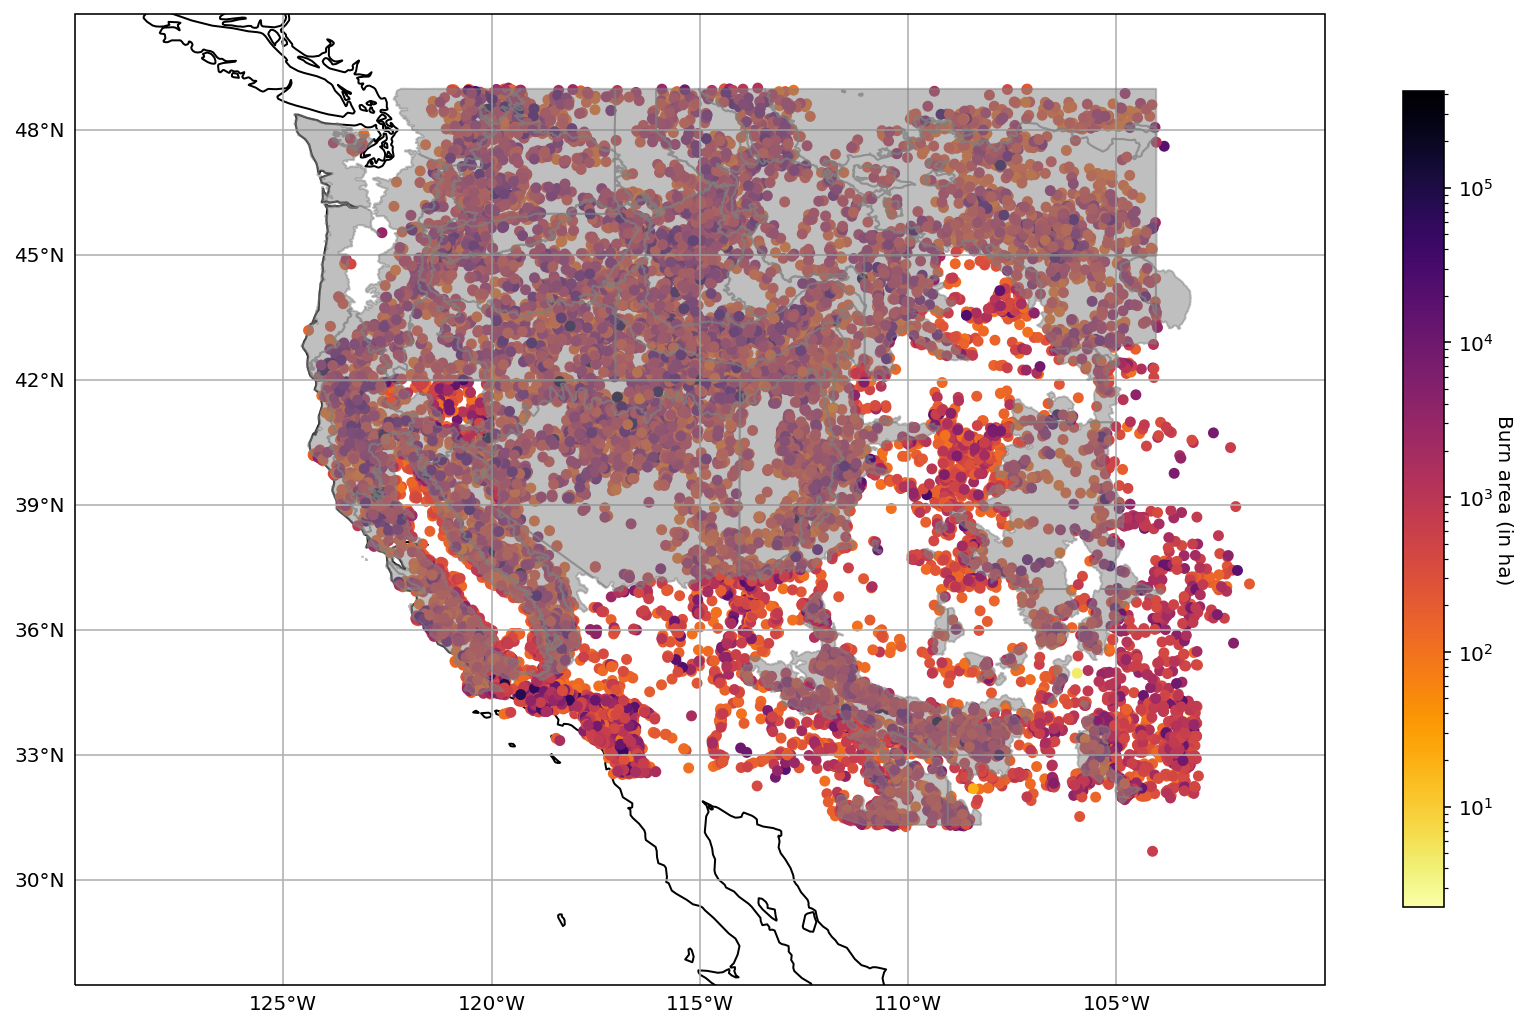

In [236]:
extent = [-130, -100, 27.5, 50] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
#ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor= cfeature.COLORS['water']);
ax.add_geometries(ncoast_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 1)
ax.add_geometries(ccoast_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(sierra_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(pnw_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(nrockies_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(mrockies_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(srockies_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(ut_mts_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(im_semidesert_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(im_desert_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(aznm_mts_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(ngreat_plains_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)
ax.add_geometries(columbia_plateau_gdf.geometry, crs= ccrs.PlateCarree(), color= 'grey', alpha= 0.5, zorder= 2)

CS= ax.scatter(wildfire_df['final_lon'], wildfire_df['final_lat'], c= wildfire_df['final_area_ha'], cmap= 'inferno_r', \
                                        norm=colors.LogNorm(vmin=wildfire_df['final_area_ha'].min(), vmax=wildfire_df['final_area_ha'].max()), 
                                        s= 20, transform=ccrs.PlateCarree())
cbar= fig.colorbar(CS, ax= ax, shrink= 0.75)
cbar.ax.set_ylabel('Burn area (in ha)', labelpad= 10, rotation= 270)

gl= ax.gridlines(draw_labels=True);
#gl.xlocator = mticker.FixedLocator([-116, -117, -118, -119, -120, -121, -122, -123, -124])
#gl.ylocator = mticker.FixedLocator([34, 36, 38, 40, 42])
gl.top_labels = False
gl.right_labels = False

### CA burned area totals

In [202]:
burnarea_ncoast_data= bailey_ecoprovince_mask(fire_file, region= "ca_north_coast");
burnarea_sierra_data= bailey_ecoprovince_mask(fire_file, region= "ca_sierra");
burnarea_ccoast_data= bailey_ecoprovince_mask(fire_file, region= "ca_cent_coast");
burnarea_scoast_data= bailey_ecoprovince_mask(fire_file, region= "ca_south_coast");
burnarea_tot_data= bailey_ecoprovince_mask(fire_file, region= "ca_total");

ann_indx_1, ann_indx_2= tindx_func(startmon= 0, duration= 12)
sum_indx_1, sum_indx_2= tindx_func(startmon= 4, duration= 5)

In [203]:
ca_ann_burnarea= np.array([np.sum(burnarea_tot_data[int(ann_indx_1[i]):int(ann_indx_2[i])]).values \
                                                                               for i in range(len(ann_indx_1))])
ncoast_ann_burnarea= np.array([np.sum(burnarea_ncoast_data[int(ann_indx_1[i]):int(ann_indx_2[i])]).values \
                                                                               for i in range(len(ann_indx_1))])
sierra_ann_burnarea= np.array([np.sum(burnarea_sierra_data[int(ann_indx_1[i]):int(ann_indx_2[i])]).values \
                                                                               for i in range(len(ann_indx_1))])
ccoast_ann_burnarea= np.array([np.sum(burnarea_ccoast_data[int(ann_indx_1[i]):int(ann_indx_2[i])]).values \
                                                                               for i in range(len(ann_indx_1))])
scoast_ann_burnarea= np.array([np.sum(burnarea_scoast_data[int(ann_indx_1[i]):int(ann_indx_2[i])]).values \
                                                                               for i in range(len(ann_indx_1))])

In [4]:
np.nansum(burnarea_data['burnarea'])

353573.5

In [212]:
ca_ann_burnarea[0]

660.4236

In [210]:
np.sum(ca_ann_burnarea)

53760.52

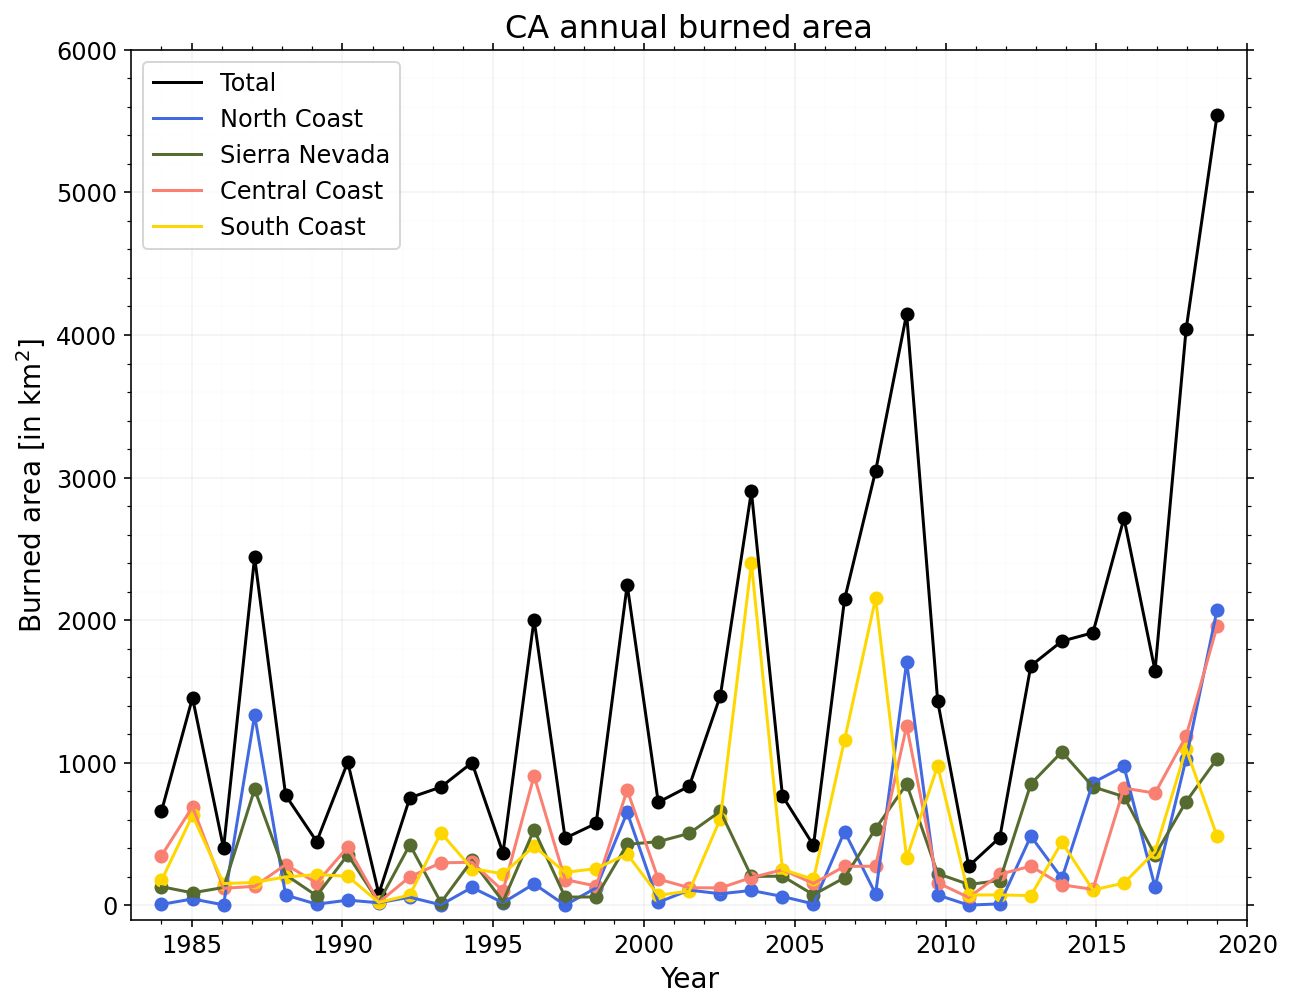

In [7]:
tot_months= 36
fig, ax= plt.subplots(figsize=(10, 8))

tot_months= len(ca_ann_burnarea) 
ax.scatter(np.linspace(1984, 2019, tot_months), ca_ann_burnarea, color= 'black');
ax.plot(np.linspace(1984, 2019, tot_months), ca_ann_burnarea, color= 'black', label= 'Total');
ax.scatter(np.linspace(1984, 2019, tot_months), ncoast_ann_burnarea, color= 'royalblue');
ax.plot(np.linspace(1984, 2019, tot_months), ncoast_ann_burnarea, color= 'royalblue', label= 'North Coast');
ax.scatter(np.linspace(1984, 2019, tot_months), sierra_ann_burnarea, color= 'darkolivegreen');
ax.plot(np.linspace(1984, 2019, tot_months), sierra_ann_burnarea, color= 'darkolivegreen', label= 'Sierra Nevada');
ax.scatter(np.linspace(1984, 2019, tot_months), ccoast_ann_burnarea, color= 'salmon');
ax.plot(np.linspace(1984, 2019, tot_months), ccoast_ann_burnarea, color= 'salmon', label= 'Central Coast');
ax.scatter(np.linspace(1984, 2019, tot_months), scoast_ann_burnarea, color= 'gold');
ax.plot(np.linspace(1984, 2019, tot_months), scoast_ann_burnarea, color= 'gold', label= 'South Coast');

ax.set_xlim(1983, 2020);
ax.set_xlabel(r'Year', fontsize= 14);
ax.set_ylim(-100, 6000);
ax.set_ylabel(r'Burned area [in ${\rm km}^2$]', fontsize= 14);

plt.minorticks_on();
plt.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
plt.legend(loc='upper left', frameon=True, fontsize=12);

ax.set_title(r'CA annual burned area', fontsize= 16);
#plt.savefig(outfilepath + 'ca_ann_burned_area.pdf', bbox_inches='tight');

#### Summer burned area

In [8]:
ca_sum_burnarea= np.array([np.sum(burnarea_tot_data[int(sum_indx_1[i]):int(sum_indx_2[i])]).values \
                                                                               for i in range(len(sum_indx_1))])
ncoast_sum_burnarea= np.array([np.sum(burnarea_ncoast_data[int(sum_indx_1[i]):int(sum_indx_2[i])]).values \
                                                                               for i in range(len(sum_indx_1))])
sierra_sum_burnarea= np.array([np.sum(burnarea_sierra_data[int(sum_indx_1[i]):int(sum_indx_2[i])]).values \
                                                                               for i in range(len(sum_indx_1))])
ccoast_sum_burnarea= np.array([np.sum(burnarea_ccoast_data[int(sum_indx_1[i]):int(sum_indx_2[i])]).values \
                                                                               for i in range(len(sum_indx_1))])
scoast_sum_burnarea= np.array([np.sum(burnarea_scoast_data[int(sum_indx_1[i]):int(sum_indx_2[i])]).values \
                                                                               for i in range(len(sum_indx_1))])

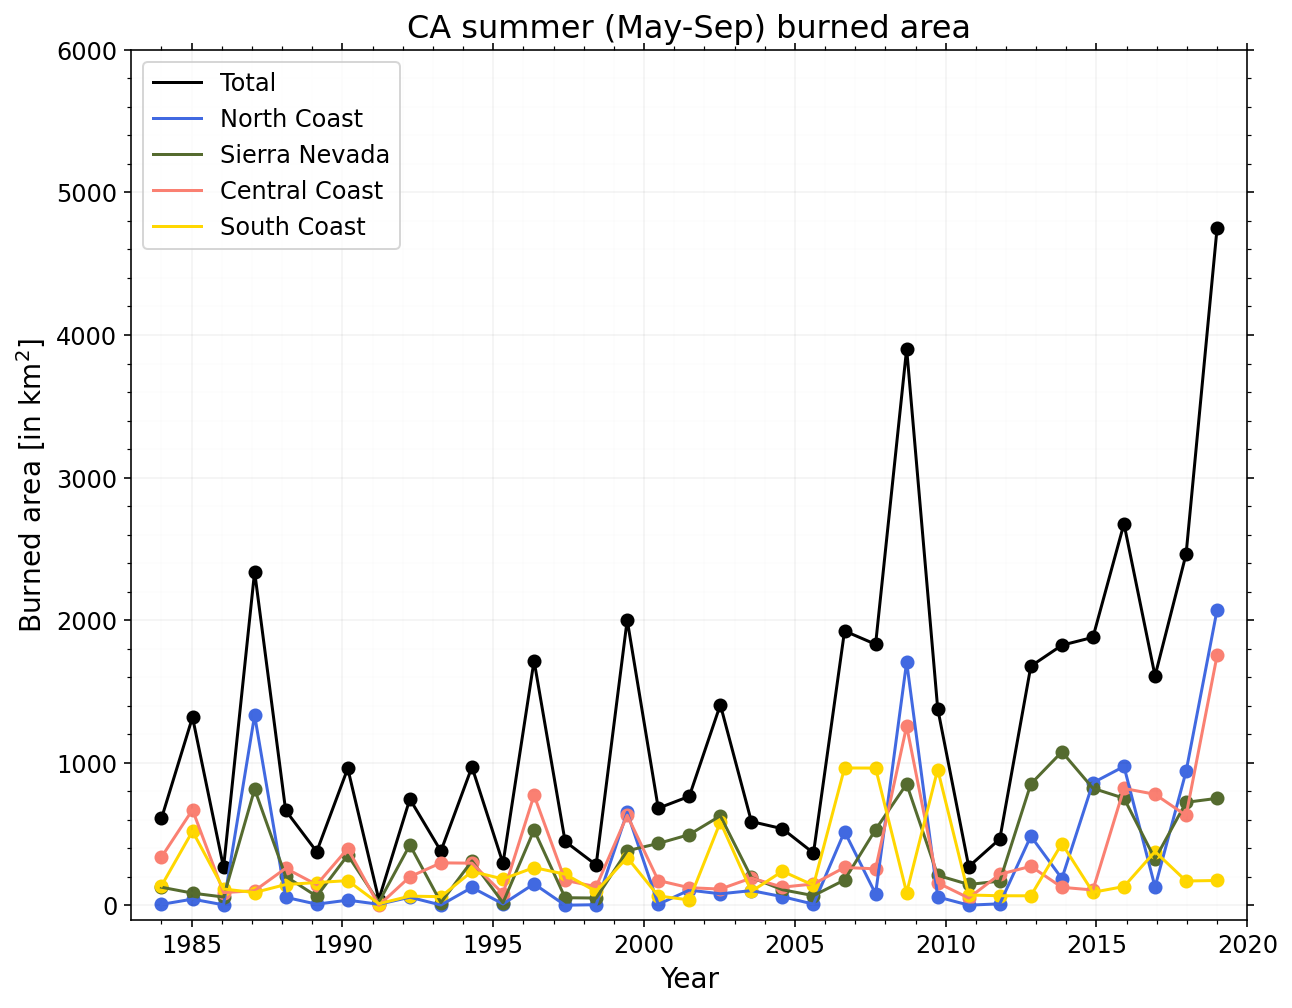

In [11]:
fig, ax= plt.subplots(figsize=(10, 8))

ax.scatter(np.linspace(1984, 2019, tot_months), ca_sum_burnarea, color= 'black');
ax.plot(np.linspace(1984, 2019, tot_months), ca_sum_burnarea, color= 'black', label= 'Total');
ax.scatter(np.linspace(1984, 2019, tot_months), ncoast_sum_burnarea, color= 'royalblue');
ax.plot(np.linspace(1984, 2019, tot_months), ncoast_sum_burnarea, color= 'royalblue', label= 'North Coast');
ax.scatter(np.linspace(1984, 2019, tot_months), sierra_sum_burnarea, color= 'darkolivegreen');
ax.plot(np.linspace(1984, 2019, tot_months), sierra_sum_burnarea, color= 'darkolivegreen', label= 'Sierra Nevada');
ax.scatter(np.linspace(1984, 2019, tot_months), ccoast_sum_burnarea, color= 'salmon');
ax.plot(np.linspace(1984, 2019, tot_months), ccoast_sum_burnarea, color= 'salmon', label= 'Central Coast');
ax.scatter(np.linspace(1984, 2019, tot_months), scoast_sum_burnarea, color= 'gold');
ax.plot(np.linspace(1984, 2019, tot_months), scoast_sum_burnarea, color= 'gold', label= 'South Coast');

ax.set_xlim(1983, 2020);
ax.set_xlabel(r'Year', fontsize= 14);
ax.set_ylim(-100, 6000);
ax.set_ylabel(r'Burned area [in ${\rm km}^2$]', fontsize= 14);

plt.minorticks_on();
plt.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
plt.legend(loc='upper left', frameon=True, fontsize=12);

ax.set_title(r'CA summer (May-Sep) burned area', fontsize= 16);
#plt.savefig(outfilepath + 'ca_sum_burned_area.pdf', bbox_inches='tight');

### CA climate-fire correlation

In [ ]:
tmax_warm_data, logpred_ca_tmax_burnarea, r_tmax= uni_lsq_regression_model(ca_sum_burnarea, tmax_file, "warm", 15)
vpd_warm_data, logpred_ca_vpd_burnarea, r_vpd= uni_lsq_regression_model(ca_sum_burnarea, es_file, "warm", 15, ea_file)
prec_warm_data, logpred_ca_prec_burnarea, r_prec= uni_lsq_regression_model(ca_sum_burnarea, prec_file, "warm", 15)
antprec_data, logpred_ca_antprec_burnarea, r_antprec= uni_lsq_regression_model(ca_sum_burnarea, prec_file, "antecedent", 15)
ETo_warm_data, logpred_ca_ETo_burnarea, r_ETo= uni_lsq_regression_model(ca_sum_burnarea, eto_file, "warm", 15)
forest_warm_data, logpred_ca_forest_burnarea, r_forest= uni_lsq_regression_model(ca_sum_burnarea, forest_file, "annual", 15)

### Consistency check for blank spots

In [183]:
burnarea_ncoast_sierra_data= ecorprovince_grid_mask(np.sum(burnarea_data['burnarea'][36:48], axis= 0), region= 'north_coast_sierra')
burnarea_ccoast_scoast_data= ecoprovince_grid_mask(np.sum(burnarea_data['burnarea'][36:48], axis= 0), region= 'central_south_coast')

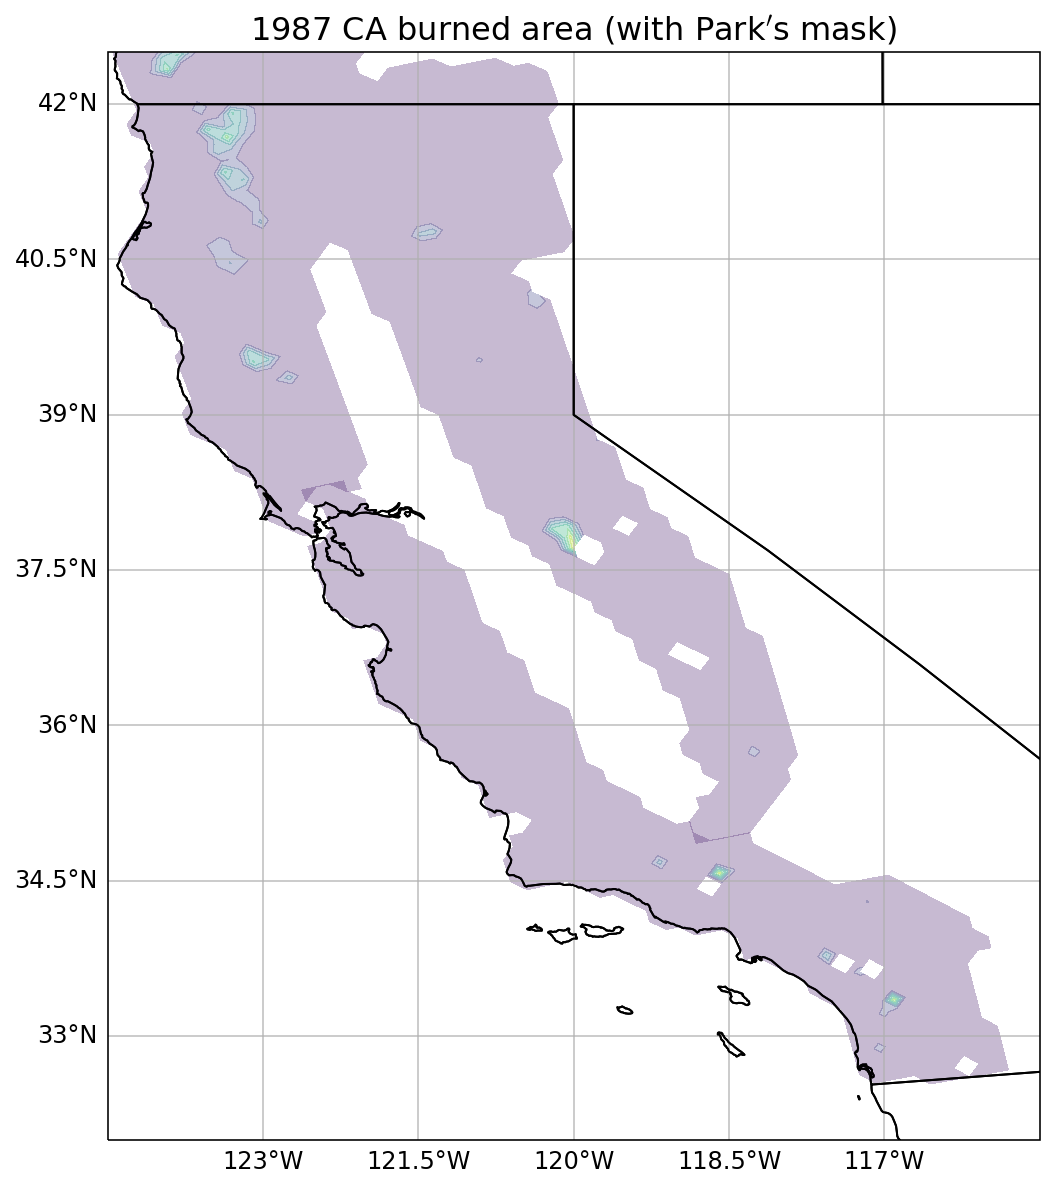

In [190]:
extent = [-124.5, -115.5, 32, 42.5] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(12, 10))
#ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent);

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl= ax.gridlines(draw_labels=True, alpha= 0.8, zorder= 1);
gl.top_labels = False;
gl.right_labels = False;
gl.xlabel_style = {'size': 12};
gl.ylabel_style = {'size': 12};

#CS = ax.contourf(lat_long_fire_grid[1], lat_long_fire_grid[0], np.sum(burnarea_tot_data.values[ind_1987], axis= 0), \
#                                                        alpha= 0.3, cmap=plt.cm.inferno)
ax.contourf(lat_long_fire_grid[1], lat_long_fire_grid[0], burnarea_ncoast_sierra_data,  \
                                                       alpha= 0.3, cmap=plt.cm.viridis)
ax.contourf(lat_long_fire_grid[1], lat_long_fire_grid[0], burnarea_ccoast_scoast_data,  \
                                                       alpha= 0.3, cmap=plt.cm.viridis)
#cbar= fig.colorbar(CS, ax= ax, shrink= 0.8)
#cbar.ax.set_ylabel(r'Burned area (in ${\rm km}^2$)', fontsize= 14, labelpad= 10, rotation= 270)

ax.set_title(r'${\rm 1987 \ CA \ burned \ area \ (with \ Park^\prime s \ mask)}$', fontsize= 16);
#plt.savefig(outfilepath + 'ca_burn_area_18_87.pdf', bbox_inches='tight');

### Three alternate ways to calculate VPD:

The values of Mar-Oct VPD obtained here are systematically different from those that are plotted in Williams et al. 2019. One possible source of error could be the way I'm averaging over different regions, however, after separately investigating the data for CA South Coast (which typically has higher values of VPD), the underestimation still persists. The following section contains more detailed investigation:

1. Mean of monthly values **_between_** March and October (for each year, unless specified otherwise),
2. March + October,
2. Median month between March and October.

In [24]:
np.array([np.mean(vpd_tot_data[fire_tim_ind][int(warm_indx_1[i]) + 1:int(warm_indx_2[i]) - 1]).values \
                                                                             for i in range(len(warm_indx_1))])

array([13.613791 , 13.227726 , 11.650294 , 13.045025 , 12.524793 ,
       11.888509 , 11.730287 , 11.669472 , 12.718663 , 11.547764 ,
       12.92205  , 11.0018015, 13.067435 , 12.22171  , 10.14015  ,
       11.76715  , 12.535902 , 13.386111 , 13.343093 , 12.945607 ,
       13.235675 , 12.1200285, 13.577971 , 13.634772 , 14.706473 ,
       14.18365  , 12.062694 , 11.906988 , 14.34236  , 13.83909  ,
       14.683578 , 13.878334 , 14.235272 , 13.736565 , 14.132737 ,
       11.786305 , 14.0025425], dtype=float32)

In [26]:
(np.array([np.mean(vpd_tot_data[fire_tim_ind][int(warm_indx_2[i])]).values for i in range(len(warm_indx_1))]) + \
            np.array([np.mean(vpd_tot_data[fire_tim_ind][int(warm_indx_1[i])]).values for i in range(len(warm_indx_1))]))

array([10.448936 ,  8.6905155, 12.236137 ,  8.392349 , 10.543168 ,
       11.428093 , 11.726826 ,  9.582267 ,  9.91935  , 11.367535 ,
        9.625957 , 10.425633 ,  9.78414  , 11.025544 ,  7.4127045,
        9.364372 ,  9.459221 ,  8.699176 , 12.186897 ,  8.874392 ,
       11.621037 , 11.572782 ,  8.028468 , 14.807812 , 12.302292 ,
       11.580766 , 10.060173 ,  8.544623 , 10.495447 , 13.801107 ,
       12.902119 , 13.644167 , 10.625113 , 11.122878 , 13.049866 ,
       12.542774 , 10.518416 ], dtype=float32)

In [27]:
0.5*(np.array([np.mean(vpd_tot_data[fire_tim_ind][int(warm_indx_2[i]) - 3]).values for i in range(len(warm_indx_1))]) + \
            np.array([np.mean(vpd_tot_data[fire_tim_ind][int(warm_indx_1[i]) + 3]).values for i in range(len(warm_indx_1))]))

array([14.3701515, 16.202084 , 15.608409 , 15.660351 , 13.5989   ,
       13.090805 , 13.368992 , 12.5724535, 14.442898 , 13.280148 ,
       16.259192 , 13.230078 , 15.804333 , 12.945927 , 13.063568 ,
       12.884601 , 15.520425 , 16.096233 , 15.622824 , 14.660673 ,
       14.756717 , 14.076067 , 15.799288 , 16.578245 , 17.411163 ,
       14.482735 , 14.101684 , 13.6930065, 16.776142 , 15.633877 ,
       16.499146 , 17.411907 , 17.546711 , 16.347382 , 16.461533 ,
       15.059766 , 16.17913  ], dtype=float32)

### Preliminary membership function

In [ ]:
def reg_indx_func_prelim(region, firepts, path_flag= False):
    
    regx_arr= []
    regy_arr= []
    reg= bailey_ecoprovince_shp(region)

    for i in tqdm(range(len(reg['geometry'].index))):
        ind_arr= reg['geometry'].index
        regx_arr.append(np.array(reg['geometry'][ind_arr[i]].exterior.coords.xy[0]).flatten())
        regy_arr.append(np.array(reg['geometry'][ind_arr[i]].exterior.coords.xy[1]).flatten())
    
    coord_arr= np.array(list(zip(np.hstack(regx_arr), np.hstack(regy_arr))))
    
    path= mpltPath.Path(coord_arr)
    loc= path.contains_points(wildfiredf_pts)
    loc_arr= np.where(loc == True)[0]
    
    if not path_flag:
        return loc_arr
    else:
        return path